<a href="https://colab.research.google.com/github/kalyanipande8/EHR/blob/main/EHRDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Setup and Library Imports

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from faker import Faker
from tabulate import tabulate

In [3]:
fake = Faker('en_US') #for consistent synthetic data generation
Faker.seed(42)

np.random.seed(42)

In [4]:
num_patients = 1000
num_admissions_per_patient = 1
num_diagnoses_per_admission = 2
num_lab_results_per_admission = 5

#Generating Synthetic Data

In [5]:
patients_data = []
for i in range(num_patients):
    patient_id = f'P{str(i+1).zfill(4)}'
    gender = np.random.choice(['Male', 'Female', 'Other'], p=[0.49, 0.49, 0.02])
    dob = fake.date_of_birth(minimum_age=18, maximum_age=90)
    ethnicity = np.random.choice(['White', 'Black', 'Asian', 'Hispanic', 'Other'])
    marital_status = np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'])
    patients_data.append({
        'patient_id': patient_id,
        'gender': gender,
        'dob': dob,
        'ethnicity': ethnicity,
        'marital_status': marital_status
    })
df_patients = pd.DataFrame(patients_data)
df_patients['dob'] = pd.to_datetime(df_patients['dob'])

print("Generated synthetic 'patients' data.")

admissions_data = []
admission_counter = 0
for patient_id in df_patients['patient_id']:
    num_admissions = np.random.poisson(num_admissions_per_patient) + 1 # At least 1 admission
    for _ in range(num_admissions):
        admission_id = f'ADM{str(admission_counter).zfill(6)}'
        admission_counter += 1
        admittime = fake.date_time_between(start_date='-5y', end_date='now')
        dischtime = admittime + pd.Timedelta(days=np.random.randint(1, 30))
        admission_type = np.random.choice(['Emergency', 'Urgent', 'Elective', 'Newborn'])
        admission_location = np.random.choice(['Emergency Room', 'Clinic', 'Transfer'])
        discharge_location = np.random.choice(['Home', 'Skilled Nursing Facility', 'Rehab', 'Expired'])
        insurance = np.random.choice(['Private', 'Medicare', 'Medicaid', 'Other'])
        hospital_expire_flag = 1 if np.random.rand() < 0.02 and discharge_location == 'Expired' else 0 # Small chance of expiry
        admissions_data.append({
            'patient_id': patient_id,
            'admission_id': admission_id,
            'admittime': admittime,
            'dischtime': dischtime,
            'admission_type': admission_type,
            'admission_location': admission_location,
            'discharge_location': discharge_location,
            'insurance': insurance,
            'hospital_expire_flag': hospital_expire_flag
        })
df_admissions = pd.DataFrame(admissions_data)
df_admissions['admittime'] = pd.to_datetime(df_admissions['admittime'])
df_admissions['dischtime'] = pd.to_datetime(df_admissions['dischtime'])

print("Generated synthetic 'admissions' data.")

diagnoses_data = []
common_diagnoses = [
    'I10', 'E11.9', 'J45.909', 'K21.9', 'N18.9', 'G40.909', 'M17.9', 'F32.9', 'J06.9', 'R51'
]
for admission_id in df_admissions['admission_id']:
    num_diagnoses = np.random.poisson(num_diagnoses_per_admission) + 1
    for _ in range(num_diagnoses):
        diagnosis_code = np.random.choice(common_diagnoses)
        diagnoses_data.append({
            'admission_id': admission_id,
            'diagnosis_code': diagnosis_code
        })
df_diagnoses = pd.DataFrame(diagnoses_data)

print("Generated synthetic 'diagnoses' data.")

lab_results_data = []
common_lab_items = {
    'Sodium': {'mean': 140, 'std': 3, 'unit': 'mEq/L'},
    'Potassium': {'mean': 4.0, 'std': 0.5, 'unit': 'mEq/L'},
    'Creatinine': {'mean': 1.0, 'std': 0.3, 'unit': 'mg/dL'},
    'Hemoglobin': {'mean': 14.0, 'std': 2.0, 'unit': 'g/dL'},
    'White Blood Cell Count': {'mean': 8.0, 'std': 3.0, 'unit': 'K/uL'}
}
for admission_id in df_admissions['admission_id']:
    num_labs = np.random.poisson(num_lab_results_per_admission) + 1
    for _ in range(num_labs):
        item_name = np.random.choice(list(common_lab_items.keys()))
        item_info = common_lab_items[item_name]
        value = np.random.normal(item_info['mean'], item_info['std'])

        if item_name == 'Hemoglobin': value = max(5.0, value)
        if item_name == 'Creatinine': value = max(0.5, value)
        if item_name == 'Potassium': value = max(2.5, value)
        if item_name == 'Sodium': value = max(120.0, value)
        if item_name == 'White Blood Cell Count': value = max(1.0, value)

        charttime = fake.date_time_between(start_date=df_admissions[df_admissions['admission_id'] == admission_id]['admittime'].iloc[0],
                                           end_date=df_admissions[df_admissions['admission_id'] == admission_id]['dischtime'].iloc[0])
        lab_results_data.append({
            'admission_id': admission_id,
            'itemid': item_name.replace(" ", "_").lower(),
            'item_name': item_name,
            'value': round(value, 2),
            'value_unit': item_info['unit'],
            'charttime': charttime
        })
df_lab_results = pd.DataFrame(lab_results_data)
df_lab_results['charttime'] = pd.to_datetime(df_lab_results['charttime'])

print("Generated synthetic 'lab_results' data.")
print("Synthetic data generation complete.")

Generated synthetic 'patients' data.
Generated synthetic 'admissions' data.
Generated synthetic 'diagnoses' data.
Generated synthetic 'lab_results' data.
Synthetic data generation complete.


#Initial Data Exploration

In [6]:
pip install pandas==2.2.2

In [7]:
print("\n--- df_patients Info ---")
print(df_patients.info())
print(tabulate(df_patients.head(), headers='keys', tablefmt='grid'))
print("\n--- df_patients Description ---")
print(df_patients.describe(include='all'))


--- df_patients Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   patient_id      1000 non-null   object        
 1   gender          1000 non-null   object        
 2   dob             1000 non-null   datetime64[ns]
 3   ethnicity       1000 non-null   object        
 4   marital_status  1000 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 39.2+ KB
None
+----+--------------+----------+---------------------+-------------+------------------+
|    | patient_id   | gender   | dob                 | ethnicity   | marital_status   |
+====+==============+==========+=====================+=============+==================+
|  0 | P0001        | Male     | 1981-01-28 00:00:00 | Other       | Divorced         |
+----+--------------+----------+---------------------+-------------+------------------+


In [8]:
print("\n--- df_admissions Info ---")
print(df_admissions.info())
print(tabulate(df_admissions.head(), headers='keys', tablefmt='grid'))
print("\n--- df_admissions Description ---")
print(df_admissions.describe(include='all'))


--- df_admissions Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   patient_id            1961 non-null   object        
 1   admission_id          1961 non-null   object        
 2   admittime             1961 non-null   datetime64[ns]
 3   dischtime             1961 non-null   datetime64[ns]
 4   admission_type        1961 non-null   object        
 5   admission_location    1961 non-null   object        
 6   discharge_location    1961 non-null   object        
 7   insurance             1961 non-null   object        
 8   hospital_expire_flag  1961 non-null   int64         
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 138.0+ KB
None
+----+--------------+----------------+----------------------------+----------------------------+------------------+----------------------+--------------

In [9]:
print("\n--- df_diagnoses Info ---")
print(df_diagnoses.info())
print(tabulate(df_diagnoses.head(), headers='keys', tablefmt='grid'))


--- df_diagnoses Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   admission_id    6019 non-null   object
 1   diagnosis_code  6019 non-null   object
dtypes: object(2)
memory usage: 94.2+ KB
None
+----+----------------+------------------+
|    | admission_id   | diagnosis_code   |
+====+================+==================+
|  0 | ADM000000      | N18.9            |
+----+----------------+------------------+
|  1 | ADM000000      | R51              |
+----+----------------+------------------+
|  2 | ADM000001      | J45.909          |
+----+----------------+------------------+
|  3 | ADM000001      | R51              |
+----+----------------+------------------+
|  4 | ADM000001      | J06.9            |
+----+----------------+------------------+


In [10]:
print("\n--- df_lab_results Info ---")
print(df_lab_results.info())
print(tabulate(df_lab_results.head(), headers='keys', tablefmt='grid'))
print("\n--- df_lab_results Description ---")
print(tabulate(df_lab_results.describe(), headers='keys', tablefmt='grid'))


--- df_lab_results Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11781 entries, 0 to 11780
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   admission_id  11781 non-null  object        
 1   itemid        11781 non-null  object        
 2   item_name     11781 non-null  object        
 3   value         11781 non-null  float64       
 4   value_unit    11781 non-null  object        
 5   charttime     11781 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 552.4+ KB
None
+----+----------------+------------+-------------+---------+--------------+----------------------------+
|    | admission_id   | itemid     | item_name   |   value | value_unit   | charttime                  |
+====+================+============+=============+=========+==============+============================+
|  0 | ADM000000      | sodium     | Sodium      |  137.47 | mEq/L    

In [11]:
print("\n--- Missing Values Check ---")
print("df_patients missing values:\n", df_patients.isnull().sum())
print("df_admissions missing values:\n", df_admissions.isnull().sum())
print("df_diagnoses missing values:\n", df_diagnoses.isnull().sum())
print("df_lab_results missing values:\n", df_lab_results.isnull().sum())


--- Missing Values Check ---
df_patients missing values:
 patient_id        0
gender            0
dob               0
ethnicity         0
marital_status    0
dtype: int64
df_admissions missing values:
 patient_id              0
admission_id            0
admittime               0
dischtime               0
admission_type          0
admission_location      0
discharge_location      0
insurance               0
hospital_expire_flag    0
dtype: int64
df_diagnoses missing values:
 admission_id      0
diagnosis_code    0
dtype: int64
df_lab_results missing values:
 admission_id    0
itemid          0
item_name       0
value           0
value_unit      0
charttime       0
dtype: int64


#Data Preprocessing

In [12]:
df_merged = pd.merge(df_admissions, df_patients, on='patient_id', how='left')

#Age at Admission
df_merged['age_at_admission'] = (df_merged['admittime'] - df_merged['dob']).dt.days / 365.25
df_merged['age_at_admission'] = df_merged['age_at_admission'].astype(int)

#Length of Stay Days
df_merged['length_of_stay_days'] = (df_merged['dischtime'] - df_merged['admittime']).dt.days
df_merged['length_of_stay_days'] = df_merged['length_of_stay_days'].apply(lambda x: max(1, x))

#Diagnosis is grouped, diagnosis codes are arranged in a list
df_diagnoses_agg = df_diagnoses.groupby('admission_id')['diagnosis_code'].apply(list).reset_index(name='diagnoses_list')
df_merged = pd.merge(df_merged, df_diagnoses_agg, on='admission_id', how='left')

df_lab_pivot = df_lab_results.pivot_table(index='admission_id', columns='item_name', values='value', aggfunc='mean')
df_lab_pivot = df_lab_pivot.add_prefix('lab_mean_')
df_merged = pd.merge(df_merged, df_lab_pivot, on='admission_id', how='left')

In [13]:
# Missing values after merging that is for lab results where not all labs were taken
# Filled with 0 for simplicity
df_merged.fillna(0, inplace=True)

#If weekend admission
df_merged['is_weekend_admission'] = df_merged['admittime'].dt.dayofweek.isin([5, 6]).astype(int)

In [14]:
categorical_cols = ['gender', 'ethnicity', 'marital_status', 'admission_type',
                    'admission_location', 'discharge_location', 'insurance']
df_processed = pd.get_dummies(df_merged, columns=categorical_cols, drop_first=True)

In [15]:
print(f"Shape of processed data: {df_processed.shape}")
print(tabulate(df_processed.head(), headers='keys', tablefmt='grid'))

Shape of processed data: (1961, 35)
+----+--------------+----------------+----------------------------+----------------------------+------------------------+---------------------+--------------------+-----------------------+--------------------------------------------------------------------------+-----------------------+-----------------------+----------------------+-------------------+-----------------------------------+------------------------+---------------+----------------+-------------------+----------------------+-------------------+-------------------+--------------------------+-------------------------+--------------------------+----------------------------+--------------------------+-------------------------+-------------------------------------+-------------------------------+---------------------------+----------------------------+-----------------------------------------------+----------------------+-------------------+---------------------+
|    | patient_id   | admissio

#Exploratory Data Analysis

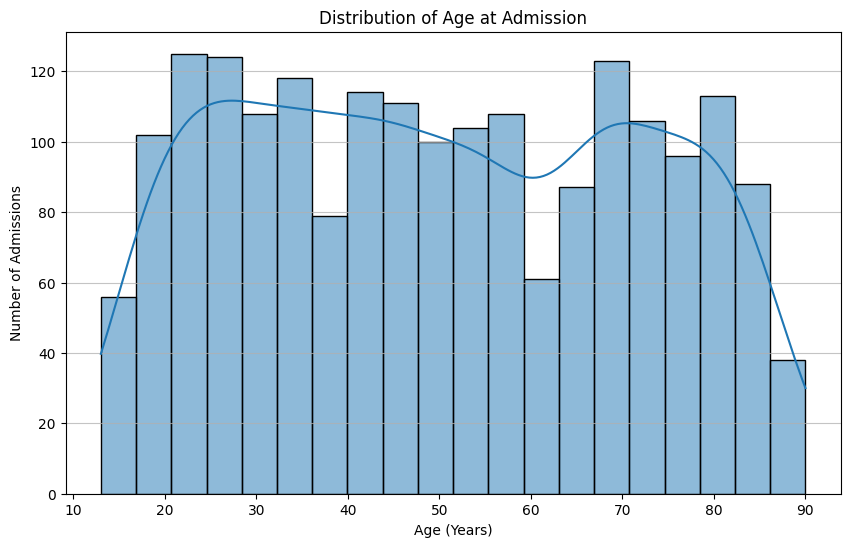

In [16]:
#Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['age_at_admission'], bins=20, kde=True)
plt.title('Distribution of Age at Admission')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Admissions')
plt.grid(axis='y', alpha=0.75)
plt.show()

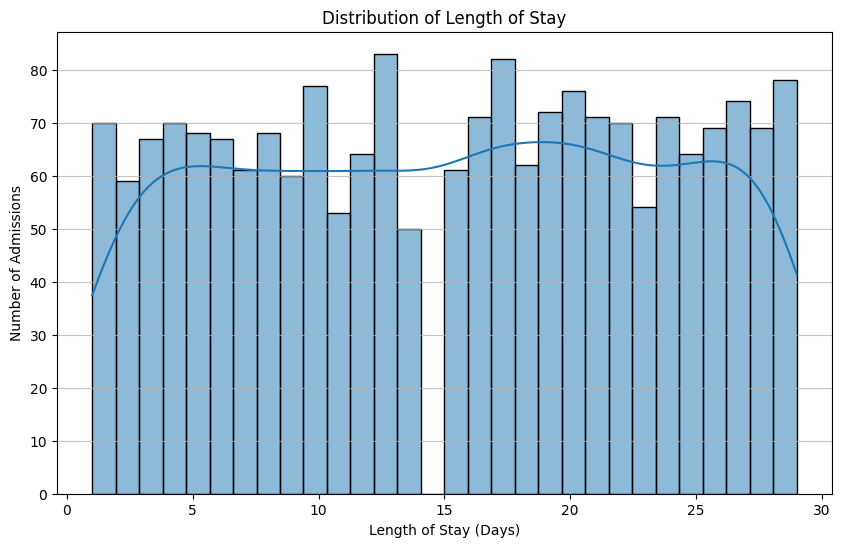

In [17]:
#Distribution of Length of Stay
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['length_of_stay_days'], bins=30, kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Number of Admissions')
plt.grid(axis='y', alpha=0.75)
plt.show()

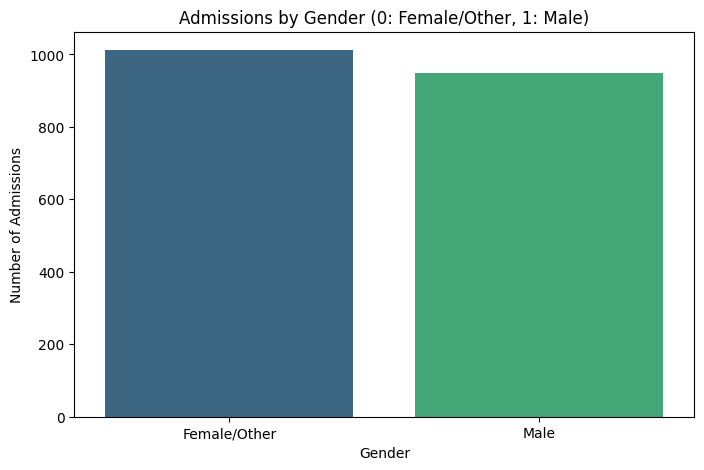

In [29]:
#Admissions by Gender
plt.figure(figsize=(8, 5))
sns.countplot(data=df_processed, x='gender_Male', hue='gender_Male', palette='viridis', legend=False)
plt.title('Admissions by Gender (0: Female/Other, 1: Male)')
plt.xlabel('Gender')
plt.ylabel('Number of Admissions')
plt.xticks(ticks=[0, 1], labels=['Female/Other', 'Male'])
plt.show()

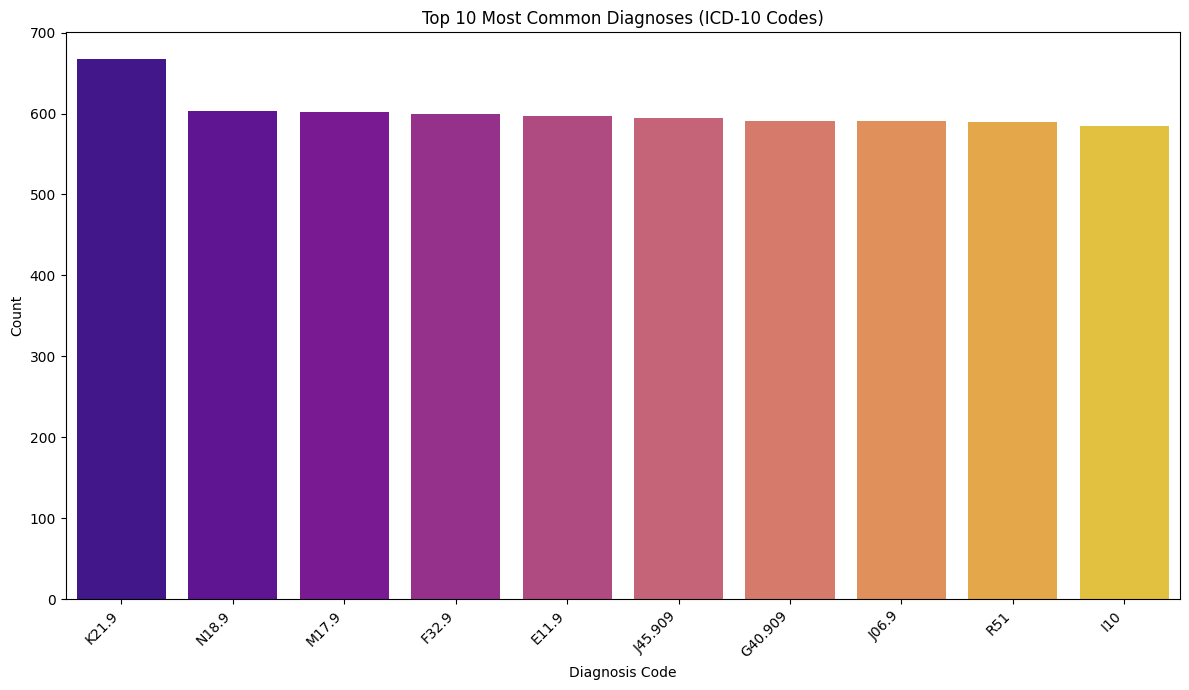

In [30]:
#Most Common Diagnosis
all_diagnoses = [diag for sublist in df_processed['diagnoses_list'].dropna() for diag in sublist]
df_common_diagnoses = pd.Series(all_diagnoses).value_counts().head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=df_common_diagnoses.index, y=df_common_diagnoses.values, palette='plasma', hue=df_common_diagnoses.index, legend=False)
plt.title('Top 10 Most Common Diagnoses (ICD-10 Codes)')
plt.xlabel('Diagnosis Code')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

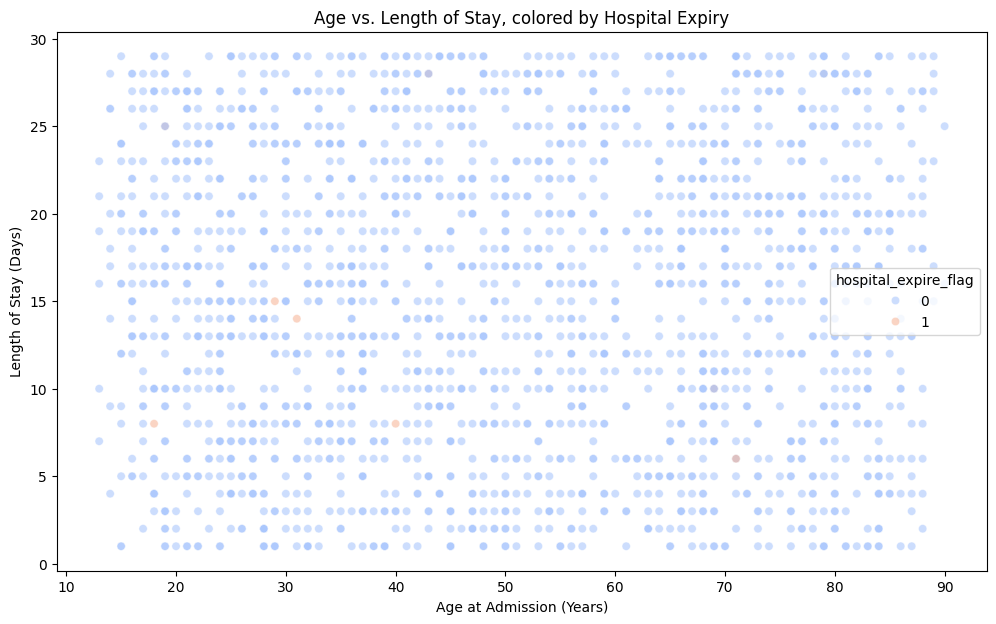

In [20]:
#Relationship between Age and Length of Stay
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_processed, x='age_at_admission', y='length_of_stay_days',
                hue='hospital_expire_flag', palette='coolwarm', alpha=0.6)
plt.title('Age vs. Length of Stay, colored by Hospital Expiry')
plt.xlabel('Age at Admission (Years)')
plt.ylabel('Length of Stay (Days)')
plt.show()

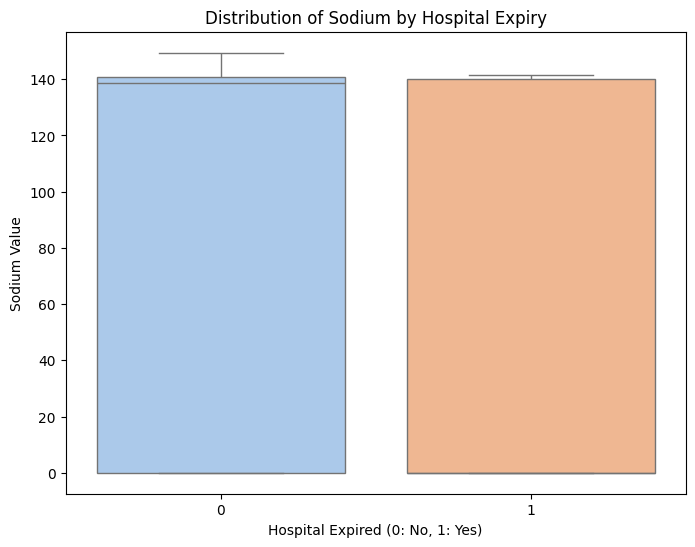

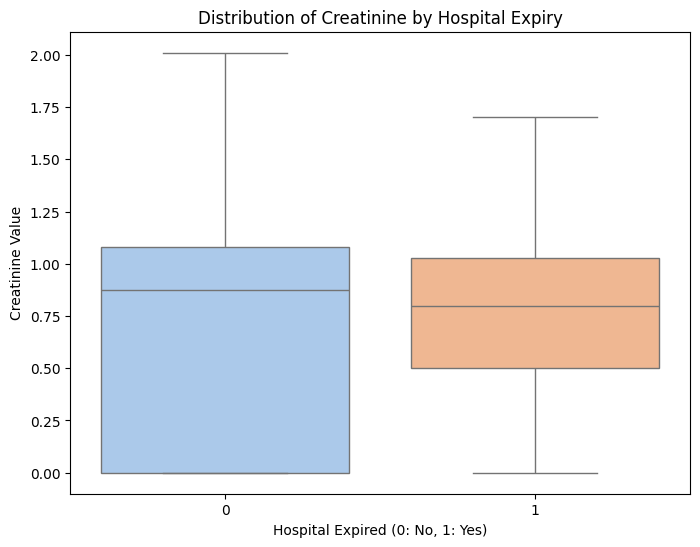

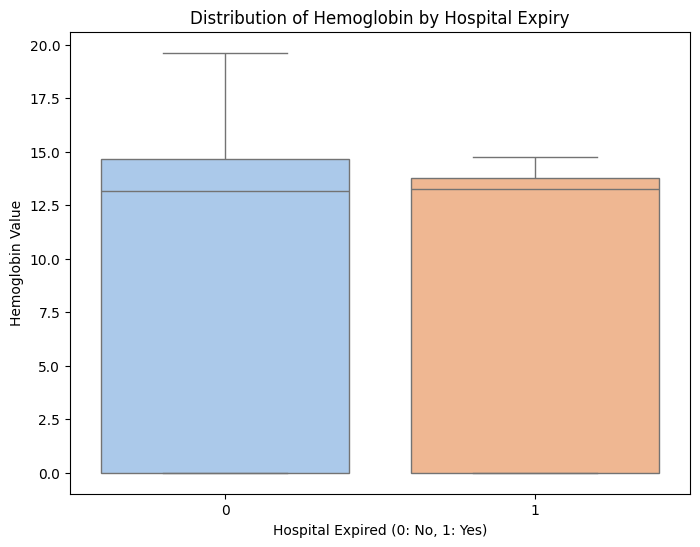

In [33]:
#Lab Items
lab_items_to_plot = ['lab_mean_Sodium', 'lab_mean_Creatinine', 'lab_mean_Hemoglobin']
for item in lab_items_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_processed, x='hospital_expire_flag', y=item,hue='hospital_expire_flag', palette='pastel', legend=False)
    plt.title(f'Distribution of {item.replace("lab_mean_", "").replace("_", " ").title()} by Hospital Expiry')
    plt.xlabel('Hospital Expired (0: No, 1: Yes)')
    plt.ylabel(f'{item.replace("lab_mean_", "").replace("_", " ").title()} Value')
    plt.show()

#Predicting Hospital Expiry

In [22]:
X = df_processed.drop(columns=[
    'patient_id', 'admission_id', 'admittime', 'dischtime', 'dob',
    'diagnoses_list', 'hospital_expire_flag'
])
y = df_processed['hospital_expire_flag']

numerical_cols_for_scaling = X.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X[numerical_cols_for_scaling] = scaler.fit_transform(X[numerical_cols_for_scaling])

In [23]:
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("First 5 rows of scaled features:")
print(tabulate(X.head(), headers='keys', tablefmt='grid'))

Features (X) shape: (1961, 28)
Target (y) shape: (1961,)
First 5 rows of scaled features:
+----+--------------------+-----------------------+-----------------------+-----------------------+----------------------+-------------------+-----------------------------------+------------------------+---------------+----------------+-------------------+----------------------+-------------------+-------------------+--------------------------+-------------------------+--------------------------+----------------------------+--------------------------+-------------------------+-------------------------------------+-------------------------------+---------------------------+----------------------------+-----------------------------------------------+----------------------+-------------------+---------------------+
|    |   age_at_admission |   length_of_stay_days |   lab_mean_Creatinine |   lab_mean_Hemoglobin |   lab_mean_Potassium |   lab_mean_Sodium |   lab_mean_White Blood Cell Count |   is_week

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Proportion of expired in training set: {y_train.mean():.2f}")
print(f"Proportion of expired in testing set: {y_test.mean():.2f}")


Training set size: 1372 samples
Testing set size: 589 samples
Proportion of expired in training set: 0.00
Proportion of expired in testing set: 0.01


In [25]:
#Assuming smaller datasets initially
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [26]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

#Model Evaluation

In [27]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9949

Confusion Matrix:
[[586   0]
 [  3   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       586
           1       0.00      0.00      0.00         3

    accuracy                           0.99       589
   macro avg       0.50      0.50      0.50       589
weighted avg       0.99      0.99      0.99       589



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Confusion Matrix

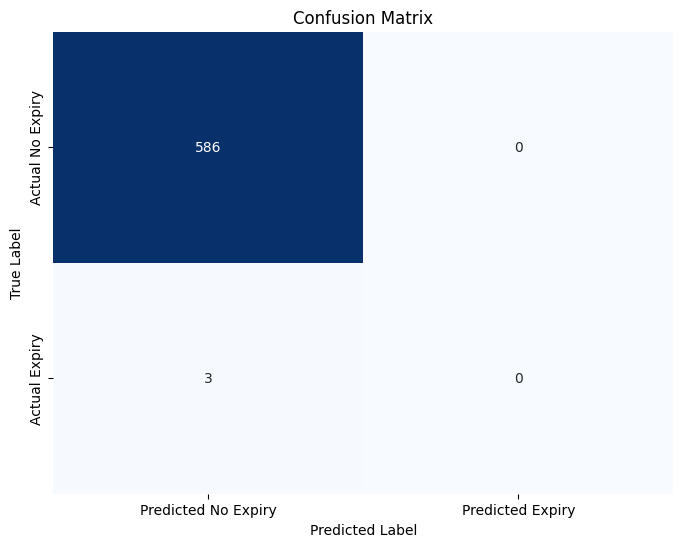

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Expiry', 'Predicted Expiry'],
            yticklabels=['Actual No Expiry', 'Actual Expiry'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()